In [3]:
import numpy as np

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
  
import tensorflow as tf



TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
from google.colab import drive
import os
import json

drive.mount('/content/drive')
PATH = '/content/drive/My Drive/DL/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Level 5

## Define model

In [0]:
def Conv2D_Block(input_tensor , n_filters):
  x = tf.keras.layers.Conv2D(filters = n_filters , kernel_size = (3 , 3) , kernel_initializer = 'he_normal' , padding = 'same')(input_tensor)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  
  x = tf.keras.layers.Conv2D(filters = n_filters , kernel_size = (3 , 3) , kernel_initializer = 'he_normal' , padding = 'same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  
  return x


def U_Net(img_tensor , n_filters = 16):
  conv1 = Conv2D_Block(img_tensor , n_filters * 1)
  pool1 = tf.keras.layers.MaxPooling2D((2 , 2))(conv1)
  pool1 = tf.keras.layers.Dropout(0.05)(pool1)
  
  conv2 = Conv2D_Block(pool1 , n_filters * 2)
  pool2 = tf.keras.layers.MaxPooling2D((2 , 2))(conv2)
  pool2 = tf.keras.layers.Dropout(0.05)(pool2)
  
  conv3 = Conv2D_Block(pool2 , n_filters * 4)
  pool3 = tf.keras.layers.MaxPooling2D((2 , 2))(conv3)
  pool3 = tf.keras.layers.Dropout(0.05)(pool3)
  
  conv4 = Conv2D_Block(pool3 , n_filters * 8)
  pool4 = tf.keras.layers.MaxPooling2D((2 , 2))(conv4)
  pool4 = tf.keras.layers.Dropout(0.05)(pool4)
  
  conv5 = Conv2D_Block(pool4 , n_filters * 16)
  
  pool6 = tf.keras.layers.Conv2DTranspose(n_filters * 8 , (3 , 3) , (2, 2) , padding = 'same')(conv5)
  pool6 = tf.keras.layers.concatenate([pool6 , conv4])
  pool6 = tf.keras.layers.Dropout(0.05)(pool6)
  conv6 = Conv2D_Block(pool6 , n_filters * 8)
  
  pool7 = tf.keras.layers.Conv2DTranspose(n_filters * 4 , (3 , 3) , (2 , 2) , padding = 'same')(conv6)
  pool7 = tf.keras.layers.concatenate([pool7 , conv3])
  pool7 = tf.keras.layers.Dropout(0.05)(pool7)
  conv7 = Conv2D_Block(pool7 , n_filters * 4)
  
  pool8 = tf.keras.layers.Conv2DTranspose(n_filters * 2 , (3 , 3) , (2 , 2) , padding = 'same')(conv7)
  pool8 = tf.keras.layers.concatenate([pool8 , conv2])
  pool8 = tf.keras.layers.Dropout(0.05)(pool8)
  conv8 = Conv2D_Block(pool8 , n_filters * 2)
  
  pool9 = tf.keras.layers.Conv2DTranspose(n_filters * 1 , (3 , 3) , (2 , 2) , padding = 'same')(conv8)
  pool9 = tf.keras.layers.concatenate([pool9 , conv1])
  pool9 = tf.keras.layers.Dropout(0.05)(pool9)
  conv9 = Conv2D_Block(pool9 , n_filters * 1)
  
  output = tf.keras.layers.Conv2D(1 , (1 , 1) , activation = 'sigmoid')(conv9)
  
  u_net = tf.keras.Model(inputs = [img_tensor] , outputs = [output])
  
  return u_net

img_tensor = tf.keras.layers.Input((128 , 128 , 3) , name = 'img')
model5 = U_Net(img_tensor)

In [0]:
import keras.backend as K

smooth = 1. 
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true) 
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f * y_true_f) + K.sum(y_pred_f * y_pred_f) + smooth)

def compound_loss(y_true, y_pred):
  loss1 = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=True)
  loss = K.mean(1. - dice_coef(y_true, y_pred) + loss1)
  return loss

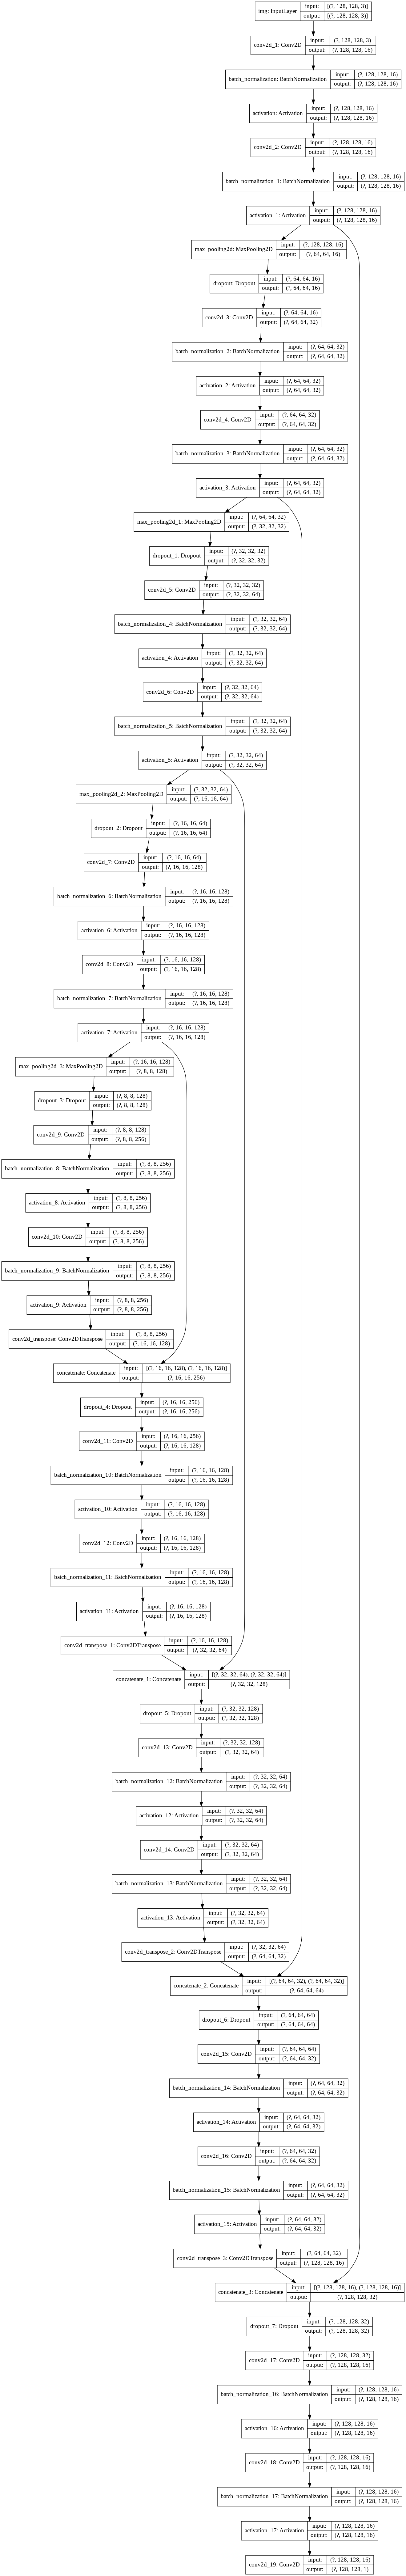

In [0]:
optimizer = tf.keras.optimizers.Adam(lr=2.5e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-6)
model5.compile(optimizer=optimizer, loss=compound_loss,
              metrics=[dice_coef])

tf.keras.utils.plot_model(model5, show_shapes=True)

## Load model

In [0]:
import os
checkpoint_path = 'model_tumor_level5.h5' # only this file is available


checkpoint_url = "https://storage.googleapis.com/dl4cv1445/ADL/model_tumor_level5.h5"

# Download the whole slide image
if not os.path.exists(checkpoint_path):
  !curl -O $checkpoint_url

In [0]:
model5.load_weights('model_tumor_level5.h5')

# Level 3

## Define model

In [0]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, dt_type, labels, batch_size=32, dim=(128,128), n_channels=3,
                 n_classes=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.dt_type = dt_type
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(10000/ self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        if self.dt_type == 'train':
            # Generate data
            IDs = []
            for i in range(self.batch_size//2):
              IDs.append(random.choice(pos_train))
              IDs.append(random.choice(neg_train))
            shuffle(IDs)
        elif self.dt_type == 'validation':
            IDs = []
            for i in range(self.batch_size//2):
              IDs.append(random.choice(pos_val))
              IDs.append(random.choice(neg_val))
            shuffle(IDs)

        # Generate data
        X, y = self.__data_generation(IDs)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, IDs):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        channels = 1
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        for i, ID in enumerate(IDs):
            # print("ID: ", ID)
            # Store sample
            X[i,] = Image.open(r'dataset/dt'+ID.split('_')[0] + '/' + ID + '.jpg')
            # convert image to numpy array
            X[i,] = asarray(X[i,])
            if self.dt_type == 'train':
                # Data augmentation
                ro = random.randint(1, 5)
                if ro == 1:
                  X[i,] = np.rot90(X[i,])
                if ro == 2:
                  X[i,] = np.fliplr(X[i,])
                if ro == 3:
                  X[i,] = np.flipud(X[i,])
                if ro == 4:
                  X[i,] = np.rot90(X[i,], 2)

            X[i,] /= 255.0

            # Store class
            y[i] = self.labels[ID]
        return X, y

In [5]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

conv_base = tf.keras.applications.DenseNet201(weights='imagenet',
                    include_top=False,
                    input_shape=(128, 128, 3))

base_model = conv_base

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
74842112/74836368 [==============================] - 6s 0us/step


In [0]:
# METRICS = [
#       tf.keras.metrics.TruePositives(name='tp'),
#       tf.keras.metrics.FalsePositives(name='fp'),
#       tf.keras.metrics.TrueNegatives(name='tn'),
#       tf.keras.metrics.FalseNegatives(name='fn'), 
#       tf.keras.metrics.BinaryAccuracy(name='accuracy'),
#       tf.keras.metrics.Precision(name='precision'),
#       tf.keras.metrics.Recall(name='recall'),
#       tf.keras.metrics.AUC(name='auc'),
# ]

In [6]:
from __future__ import absolute_import, division, print_function, unicode_literals
import keras.backend as K


global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
# build a new model reusing the pretrained base
model3 = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(256, (1,1), activation='relu'),
  tf.keras.layers.Flatten(input_shape=(4,4,512)), 
  tf.keras.layers.Dense(
          64, activation='relu',
          input_shape=(4, 4, 512),
          kernel_initializer=tf.keras.initializers.he_normal(),
          bias_initializer='zeros'),
  # tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(
          16, activation='relu',
          kernel_initializer=tf.keras.initializers.he_normal(),
          bias_initializer='zeros'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])



Using TensorFlow backend.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


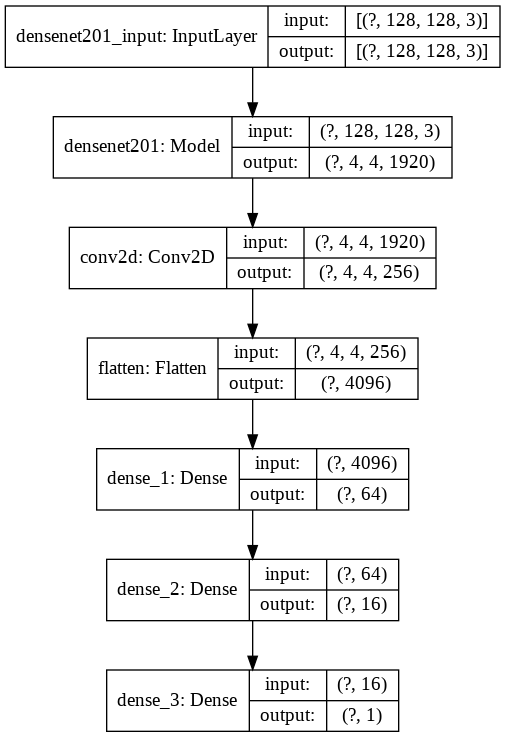

In [7]:
# rmsprop = RMSprop(lr=0.1)
# adam = tf.keras.optimizers.Adam(lr=0.01)
sgd = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)
def loss_fn(y_true, y_pred):
  loss = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=True)
  return loss

model3.compile(optimizer=sgd, loss=loss_fn,
              metrics=['accuracy'])

tf.keras.utils.plot_model(model3, show_shapes=True)

## Load model

In [8]:
import os
checkpoint_path = 'model_tumor_level3.h5' # only this file is available


checkpoint_url = "https://storage.googleapis.com/dl4cv1445/ADL/model_tumor_level3.h5"

# Download the whole slide image
if not os.path.exists(checkpoint_path):
  !curl -O $checkpoint_url

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 73.5M  100 73.5M    0     0  32.1M      0  0:00:02  0:00:02 --:--:-- 32.1M


In [0]:
model3.load_weights('model_tumor_level3.h5')

In [0]:
desired_layer3 = model3.get_layer('dense_2').output

# Create the feature extraction model
desired3 = tf.keras.Model(inputs=model3.input, outputs=desired_layer3)

# Level 1

## Define model

In [0]:
"""## Define model"""

import random
from random import shuffle
from random import sample
from PIL import Image
# labels = {'id-1': 0, 'id-2': 1, 'id-3': 2, 'id-4': 1}
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, dt_type, labels, batch_size=32, dim=(128,128), n_channels=3,
                 n_classes=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.dt_type = dt_type
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(10000/ self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate data
        X, y = self.__data_generation('00')

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        # self.indexes = np.arange(len(self.list_IDs))
        # if self.shuffle == True:
        #     np.random.shuffle(self.indexes)
        import gc
        gc.collect()

    def __data_generation(self, I):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        if self.dt_type == 'train':
            # Generate data
            IDs = []
            for i in range(self.batch_size//2):
              IDs.append(random.choice(pos_train))
              IDs.append(random.choice(neg_train))
            shuffle(IDs)
        elif self.dt_type == 'validation':
            IDs = []
            for i in range(self.batch_size//2):
              IDs.append(random.choice(pos_val))
              IDs.append(random.choice(neg_val))
            shuffle(IDs)
        # Initialization
        channels = 1
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        for i, ID in enumerate(IDs):
            # print("ID: ", ID)
            # Store sample
            X[i,] = Image.open(r'dt'+ID.split('_')[0] + '/' + ID + '.jpg')
            # convert image to numpy array
            X[i,] = asarray(X[i,])
            if self.dt_type == 'train':
                # Data augmentation
                ro = random.randint(1, 5)
                if ro == 1:
                  X[i,] = np.rot90(X[i,])
                if ro == 2:
                  X[i,] = np.fliplr(X[i,])
                if ro == 3:
                  X[i,] = np.flipud(X[i,])
                if ro == 4:
                  X[i,] = np.rot90(X[i,], 2)

            X[i,] /= 255.0

            # Store class
            y[i] = self.labels[ID]
        return X, y

In [0]:

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

conv_base = tf.keras.applications.DenseNet201(weights='imagenet',
                    include_top=False,
                    input_shape=(128, 128, 3))

base_model = conv_base

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import keras.backend as K


global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
# build a new model reusing the pretrained base
model1 = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(256, (1,1), activation='elu'),
  tf.keras.layers.Flatten(input_shape=(4,4,512)),
  tf.keras.layers.Dense(
          128, activation='elu',
          input_shape=(4, 4, 512),
          kernel_initializer=tf.keras.initializers.he_normal(),
          bias_initializer='zeros'),
  tf.keras.layers.Dense(
          64, activation='elu',
          kernel_initializer=tf.keras.initializers.he_normal(),
          bias_initializer='zeros'),
  # tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(
          16, activation='elu',
          kernel_initializer=tf.keras.initializers.he_normal(),
          bias_initializer='zeros'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])



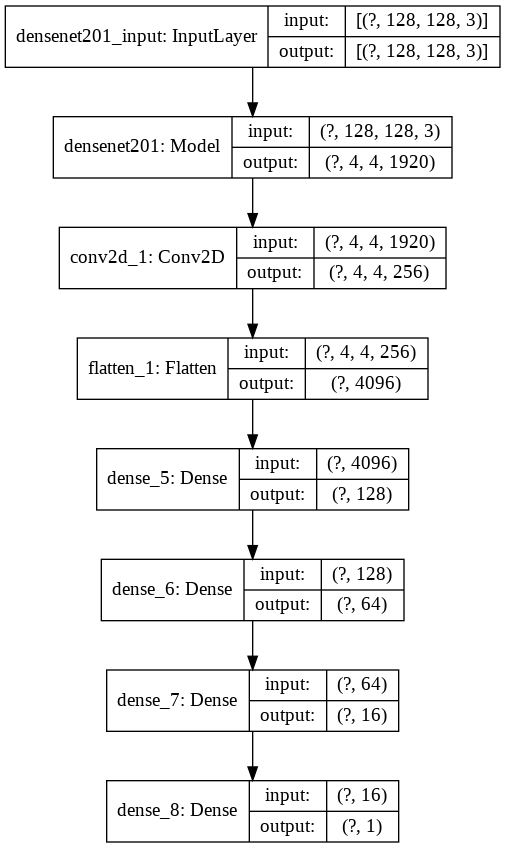

In [27]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
def loss_fn(y_true, y_pred):
  loss = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=True)
  return loss

model1.compile(optimizer=sgd, loss=loss_fn,
              metrics=['accuracy'])

tf.keras.utils.plot_model(model1, show_shapes=True)

## Load model

In [28]:
import os
checkpoint_path = 'model_tumor_level1.h5' # only this file is available


checkpoint_url = "https://storage.googleapis.com/dl4cv1445/ADL/model_tumor_level1.h5"

# Download the whole slide image
if not os.path.exists(checkpoint_path):
  !curl -O $checkpoint_url


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 74.5M  100 74.5M    0     0  33.8M      0  0:00:02  0:00:02 --:--:-- 33.8M


In [0]:
model1.load_weights('model_tumor_level1.h5')

In [0]:
desired_layer1 = model1.get_layer('dense_7').output

# Create the feature extraction model
desired1 = tf.keras.Model(inputs=model1.input, outputs=desired_layer1)

# Level 0

## Define model

In [0]:
"""## Define model"""

import random
from random import shuffle
from random import sample
from PIL import Image
# labels = {'id-1': 0, 'id-2': 1, 'id-3': 2, 'id-4': 1}
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, dt_type, labels, batch_size=32, dim=(128,128), n_channels=3,
                 n_classes=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.dt_type = dt_type
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(10000/ self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate data
        X, y = self.__data_generation('00')

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        # self.indexes = np.arange(len(self.list_IDs))
        # if self.shuffle == True:
        #     np.random.shuffle(self.indexes)
        import gc
        gc.collect()

    def __data_generation(self, I):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        if self.dt_type == 'train':
            # Generate data
            IDs = []
            for i in range(self.batch_size//2):
              IDs.append(random.choice(pos_train))
              IDs.append(random.choice(neg_train))
            shuffle(IDs)
        elif self.dt_type == 'validation':
            IDs = []
            for i in range(self.batch_size//2):
              IDs.append(random.choice(pos_val))
              IDs.append(random.choice(neg_val))
            shuffle(IDs)
        # Initialization
        channels = 1
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        for i, ID in enumerate(IDs):
            # print("ID: ", ID)
            # Store sample
            X[i,] = Image.open(r'dt'+ID.split('_')[0] + '/' + ID + '.jpg')
            # convert image to numpy array
            X[i,] = asarray(X[i,])
            if self.dt_type == 'train':
                # Data augmentation
                ro = random.randint(1, 5)
                if ro == 1:
                  X[i,] = np.rot90(X[i,])
                if ro == 2:
                  X[i,] = np.fliplr(X[i,])
                if ro == 3:
                  X[i,] = np.flipud(X[i,])
                if ro == 4:
                  X[i,] = np.rot90(X[i,], 2)

            X[i,] /= 255.0

            # Store class
            y[i] = self.labels[ID]
        return X, y

In [0]:

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

conv_base = tf.keras.applications.DenseNet201(weights='imagenet',
                    include_top=False,
                    input_shape=(128, 128, 3))

base_model = conv_base

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import keras.backend as K


global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
# build a new model reusing the pretrained base
model0 = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(256, (1,1), activation='elu'),
  tf.keras.layers.Flatten(input_shape=(4,4,512)),
  tf.keras.layers.Dense(
          128, activation='elu',
          input_shape=(4, 4, 512),
          kernel_initializer=tf.keras.initializers.he_normal(),
          bias_initializer='zeros'),
  tf.keras.layers.Dense(
          64, activation='elu',
          kernel_initializer=tf.keras.initializers.he_normal(),
          bias_initializer='zeros'),
  # tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(
          16, activation='elu',
          kernel_initializer=tf.keras.initializers.he_normal(),
          bias_initializer='zeros'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])



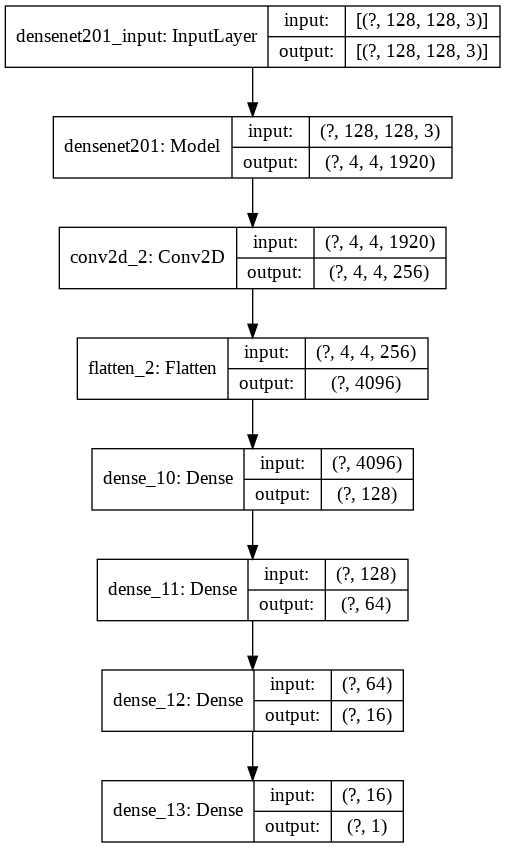

In [34]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
def loss_fn(y_true, y_pred):
  loss = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=True)
  return loss

model0.compile(optimizer=sgd, loss=loss_fn,
              metrics=['accuracy'])

tf.keras.utils.plot_model(model0, show_shapes=True)

## Load model

In [35]:
import os
checkpoint_path = 'model_tumor_level0.h5' # only this file is available


checkpoint_url = "https://storage.googleapis.com/dl4cv1445/ADL/model_tumor_level0.h5"

# Download the whole slide image
if not os.path.exists(checkpoint_path):
  !curl -O $checkpoint_url


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 74.5M  100 74.5M    0     0  24.3M      0  0:00:03  0:00:03 --:--:-- 24.3M


In [0]:
model0.load_weights('model_tumor_level0.h5')

In [0]:
desired_layer0 = model0.get_layer('dense_12').output

# Create the feature extraction model
desired0 = tf.keras.Model(inputs=model0.input, outputs=desired_layer0)

## Concatenation

In [0]:
x0 = tf.random.normal((1, 128, 128, 3))
x1 = tf.random.normal((1, 128, 128, 3))
x3 = tf.random.normal((1, 128, 128, 3))
y = 0

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.d0 = desired0
    self.d1 = desired1
    self.d3 = desired3
    self.dense = Dense(128, activation='relu')
    self.last = Dense(1, activation='sigmoid')

  def call(self, x0, x1, x3):
    a1 = self.d0(x0)
    a2 = self.d1(x1)
    a3 = self.d3(x3)
    print('a1.shape: ', a1.shape)
    print('a2.shape: ', a2.shape)
    print('a3.shape: ', a3.shape)
    feat = tf.concat([a1, a2, a3])
    feat = self.dense(feat)

    return self.last(feat)

# Create an instance of the model
model = MyModel()

In [0]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=50, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.000001, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(PATH_models+'model_tumor.h5', verbose=1, save_best_only=True, save_weights_only=True),
    DisplayCallback()
]

In [0]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
def loss_fn(y_true, y_pred):
  loss = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=True)
  return loss

model.compile(optimizer=sgd, loss=loss_fn,
              metrics=['accuracy'])

EPOCHS = 600
VAL_SUBSPLITS = 5


model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          # validation_steps=VALIDATION_STEPS,
                          validation_data=val_dataset,
                          callbacks=callbacks)